# <b>Mục tiêu</b>
- Thu thập dữ liệu về thời tiết tại TP HCM theo từng ngày từ năm 2010 đến năm 2021.
<br><br>
- Các trường dữ liệu sẽ thu thập bao gồm:
    + Weather Type: Loại thời tiết
    + Highest Temperature: Nhiệt độ cao nhất trong ngày ($^\circ C$)
    + Lowest Temperature: Nhiệt độ thấp nhất trong ngày ($^\circ C$)
    + Wind Speed: Tốc độ gió (km/h)
    + Rain: Lượng mưa (mm)
    + Humidity: Độ ẩm (%)
    + Cloud: Độ che phủ của mây (%)
    + Pressure: Áp suất không khí (mb)
<br><br>
- Trả về:
    + hcm_weather_info.csv: File CSV chứa dữ liệu.
    + feature_description.csv: File CSV mô tả thông tin các trường dữ liệu.

# <b>Import</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

%pip install bs4

from bs4 import BeautifulSoup

%pip install Selenium

%pip install webdriver-manager

from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

# <b>Thu thập dữ liệu</b>

In [2]:
url = 'https://www.worldweatheronline.com/ho-chi-minh-city-weather-history/vn.aspx'
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
months = 12
year = 2010

# Thiết lập ChromeDriver
service = ChromeService(executable_path= ChromeDriverManager().install())
options = Options()
options.add_argument('--headless')                              # Ẩn màn hình Chrome, chỉ chạy dưới nền
options.add_argument('--window-size=1920, 1200')
driver = webdriver.Chrome(service= service, options= options)    # Khởi tạo Driver

driver.get(url)

weather_info_list = []              # List chứa dữ liệu thời tiết TP HCM 2010 - 2021
exception_occured = False

for month in range(months):
    if exception_occured: break
    for date in range(days[month]):
        # Nhập ngày cần tìm thông tin thời tiết
        search_date = driver.find_element(by= By.XPATH, value= '//*[@id="ctl00_MainContentHolder_txtPastDate"]')
        driver.execute_script(f'arguments[0].setAttribute("value", "{year}-{month + 1:02}-{date + 1:02}");', search_date)      # Eg: 2010-02-01 

        # Nhấn nút 'Get Weather' để hiện thị dữ liệu thời tiết
        get_weather_button = driver.find_element(by= By.XPATH, value= '//*[@id="ctl00_MainContentHolder_butShowPastWeather"]')
        driver.execute_script('arguments[0].click();', get_weather_button)

        try:
            # Chờ thao tác tìm kiếm kết thúc mới tiến hành thu thập dữ liệu
            weather_info = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, '//*[@id="aspnetForm"]/section[2]/div/div/div[1]/div[6]/div[2]'))
            )

            for i in range(2, 14):
                # Năm
                year_info = weather_info.find_element(by= By.XPATH, value= f'//*[@id="aspnetForm"]/section[2]/div/div/div[1]/div[6]/div[2]/div[{i}1]')

                # Loại thời tiết - Weather Type
                weather_type_info = weather_info.find_element(by= By.XPATH, value= f'//*[@id="aspnetForm"]/section[2]/div/div/div[1]/div[6]/div[2]/div[{i}2]/img')

                # Nhiệt độ cao nhất - Highest Temperature
                highest_temp_info = weather_info.find_element(by= By.XPATH, value= f'//*[@id="aspnetForm"]/section[2]/div/div/div[1]/div[6]/div[2]/div[{i}3]')

                # Nhiệt độ thấp nhất - Lowest Temperature
                lowest_temp_info = weather_info.find_element(by= By.XPATH, value= f'//*[@id="aspnetForm"]/section[2]/div/div/div[1]/div[6]/div[2]/div[{i}4]')

                # Tốc độ gió - Wind Speed
                wind_speed_info = weather_info.find_element(by= By.XPATH, value= f'//*[@id="aspnetForm"]/section[2]/div/div/div[1]/div[6]/div[2]/div[{i}5]')

                # Lượng mưa - Rain
                rain_info = weather_info.find_element(by= By.XPATH, value= f'//*[@id="aspnetForm"]/section[2]/div/div/div[1]/div[6]/div[2]/div[{i}6]')

                # Độ ẩm - Humidity
                humidity_info = weather_info.find_element(by= By.XPATH, value= f'//*[@id="aspnetForm"]/section[2]/div/div/div[1]/div[6]/div[2]/div[{i}7]')

                # Độ che phủ của mây - Cloud
                cloud_info = weather_info.find_element(by= By.XPATH, value= f'//*[@id="aspnetForm"]/section[2]/div/div/div[1]/div[6]/div[2]/div[{i}8]')

                # Áp suất không khí - Pressure
                pressure_info = weather_info.find_element(by= By.XPATH, value= f'//*[@id="aspnetForm"]/section[2]/div/div/div[1]/div[6]/div[2]/div[{i}9]')
                
                # Lưu dữ liệu vào dictionary
                weather_in_date = {
                    'Date': f'{int(year_info.text)}-{month + 1:02}-{date + 1:02}',
                    'Weather Type': weather_type_info.get_attribute("title"),
                    'Highest Temperature': re.findall(r'\d+', highest_temp_info.text)[0],
                    'Lowest Temperature': re.findall(r'\d+', lowest_temp_info.text)[0],
                    'Wind Speed': re.findall(r'\d+', wind_speed_info.text)[0],
                    'Rain': re.findall(r'\d+.\d+', rain_info.text)[0],
                    'Humidity': re.findall(r'\d+', humidity_info.text)[0],
                    'Cloud': re.findall(r'\d+', cloud_info.text)[0],
                    'Pressure': re.findall(r'\d+', pressure_info.text)[0],
                }
                
                # Thêm thông tin lấy được vào list
                weather_info_list.append(weather_in_date)

        except Exception as e:
            print('An exception has occurred: ', e)
            exception_occured = True
            break

driver.quit()

hcm_weather_info_df = pd.DataFrame(weather_info_list) 
hcm_weather_info_df['Date'] = pd.to_datetime(hcm_weather_info_df['Date'], format= '%Y-%m-%d')
hcm_weather_info_df = hcm_weather_info_df.sort_values(by= 'Date').reset_index(drop= True)
hcm_weather_info_df

feature_description_list = [
    {'Feature': 'Weather Type', 'Description': 'Loại thời tiết'},
    {'Feature': 'Highest Temperature', 'Description': u'Nhiệt độ cao nhất trong ngày (\N{DEGREE SIGN}C)'},
    {'Feature': 'Lowest Temperature', 'Description': u'Nhiệt độ thấp nhất trong ngày (\N{DEGREE SIGN}C)'},
    {'Feature': 'Wind Speed', 'Description': 'Tốc độ gió (km/h)'},
    {'Feature': 'Rain', 'Description': 'Lượng mưa (mm)'},
    {'Feature': 'Humidity', 'Description': 'Độ ẩm (%)'},
    {'Feature': 'Cloud', 'Description': 'Độ che phủ của mây (%)'},
    {'Feature': 'Pressure', 'Description': 'Áp suất không khí (mb)'},
]

feature_description_df = pd.DataFrame(feature_description_list)
feature_description_df

# <b>Lưu dữ liệu</b>

# Tạo thư mục lưu dữ liệu
list_file = os.listdir()
if 'Data' not in list_file:
     os.makedirs("Data")

# Lưu dữ liệu vào file CSV
hcm_weather_info_df.to_csv('./Data/hcm_weather_info.csv', index= False)
feature_description_df.to_csv('./Data/feature_description.csv', index= False)

# KHÁM PHÁ DỮ LIỆU

In [3]:
df = pd.read_csv('Data/hcm_weather_info.csv')
df.head()

,Date,Weather Type,Average Temperature,Highest Temperature,Lowest Temperature,Wind Speed,Rain,Humidity,Cloud,Pressure
0,2010-01-01,Partly cloudy,28.4,34,24,6,0.0,59,20,1010
1,2010-01-02,Cloudy,27.0,32,24,7,0.0,61,48,1010
2,2010-01-03,Partly cloudy,28.1,33,26,7,0.0,65,37,1010
3,2010-01-04,Partly cloudy,28.2,35,25,9,0.1,61,42,1009
4,2010-01-05,Partly cloudy,28.8,35,26,10,0.0,57,35,1009


## ý nghĩa của các cột
* **Date: thời gian**</br>
* **Weather Type: Loại thời tiết**</br>
* **Highest Temperature: Nhiệt độ cao nhất trong ngày (°C)**</br>
* **Lowest Temperature: Nhiệt độ thấp nhất trong ngày (°C)**</br>
* **Wind Speed: Tốc độ gió (km/h)**</br>
* **Rain: Lượng mưa (mm)**</br>
* **Humidity: Độ ẩm (%)**</br>
* **Cloud: Độ che phủ của mây (%)**</br>
* **Pressure: Áp suất không khí (mb)** 

## số dòng va cột của dữ liệu

In [4]:
df.shape

(4380, 10)

- **như vậy dữ liệu có 4380 dòng và 9 cột**

## Xem kiểu dữ liệu của các cột

In [5]:
df.dtypes

Date                    object
Weather Type            object
Average Temperature    float64
Highest Temperature      int64
Lowest Temperature       int64
Wind Speed               int64
Rain                   float64
Humidity                 int64
Cloud                    int64
Pressure                 int64
dtype: object

## Chuyển kiểu dữ liệu cột 'Date' về datetime

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.dtypes

Date                   datetime64[ns]
Weather Type                   object
Average Temperature           float64
Highest Temperature             int64
Lowest Temperature              int64
Wind Speed                      int64
Rain                          float64
Humidity                        int64
Cloud                           int64
Pressure                        int64
dtype: object

## có cột nào bị thiếu dữ liệu không

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 4380 non-null   datetime64[ns]
 1   Weather Type         4380 non-null   object        
 2   Average Temperature  4380 non-null   float64       
 3   Highest Temperature  4380 non-null   int64         
 4   Lowest Temperature   4380 non-null   int64         
 5   Wind Speed           4380 non-null   int64         
 6   Rain                 4380 non-null   float64       
 7   Humidity             4380 non-null   int64         
 8   Cloud                4380 non-null   int64         
 9   Pressure             4380 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 342.3+ KB


- **như vậy không có cột bị thiếu dữ liệu**

## kiểm tra có dữ liệu trùng lắp không

In [9]:
df.duplicated().unique()

array([False])

- không có

## kiểm tra phân bố của dữ liệu

### các cột numeric

In [10]:
df.columns

Index(['Date', 'Weather Type', 'Average Temperature', 'Highest Temperature',
       'Lowest Temperature', 'Wind Speed', 'Rain', 'Humidity', 'Cloud',
       'Pressure'],
      dtype='object')

In [11]:
numeric = ['Date', 'Highest Temperature', 'Lowest Temperature',
       'Wind Speed', 'Rain', 'Humidity', 'Cloud', 'Pressure']

In [12]:
df[numeric].dtypes

Date                   datetime64[ns]
Highest Temperature             int64
Lowest Temperature              int64
Wind Speed                      int64
Rain                          float64
Humidity                        int64
Cloud                           int64
Pressure                        int64
dtype: object

In [13]:
def lower_quartile(s):
    s = s[~np.isnan(s)]
    sorted_val = np.sort(s.values)
    lenght = len(s)
    q1 = int(0.25 * lenght)
    return sorted_val[q1]
def median(s):
    s = s[~np.isnan(s)]
    sorted_val = np.sort(s.values)
    lenght = len(s)
    q1 = int(0.5 * lenght)
    return sorted_val[q1]
def upper_quartile(s):
    s = s[~np.isnan(s)]
    sorted_val = np.sort(s.values)
    lenght = len(s)
    q1 = int(0.75 * lenght)
    return sorted_val[q1]
def mean(s):
    return s.mean()

In [14]:
nume_profiles_df = df[numeric].agg([min, lower_quartile, median, upper_quartile, max, mean]).round(1)
nume_profiles_df

,Date,Highest Temperature,Lowest Temperature,Wind Speed,Rain,Humidity,Cloud,Pressure
min,2010-01-01 00:00:00.000000000,22.0,16.0,3.0,0.0,45.0,0.0,1003.0
lower_quartile,2013-01-01 00:00:00.000000000,32.0,24.0,7.0,0.1,66.0,23.0,1008.0
median,2016-01-01 00:00:00.000000000,33.0,25.0,9.0,3.3,75.0,34.0,1009.0
upper_quartile,2019-01-01 00:00:00.000000000,35.0,26.0,12.0,11.1,82.0,50.0,1011.0
max,2021-12-31 00:00:00.000000000,41.0,30.0,26.0,253.3,96.0,99.0,1016.0
mean,2015-12-31 23:01:48.493150720,33.0,25.2,9.4,7.5,73.6,37.0,1009.3


### các cột categori

In [15]:
categori = ['Weather Type']

In [16]:
def num_diff_vals(s):
    ndv = s.nunique()
    return ndv

def diff_vals(s):
    dv = s.unique()
    dv = dv[~pd.isna(dv)]
    return dv

In [17]:
cate_profiles_df = df[categori].agg([num_diff_vals, diff_vals])
cate_profiles_df

,Weather Type
num_diff_vals,20
diff_vals,"[Partly cloudy, Cloudy, Sunny, Patchy light dr..."


# đặt ra câu hỏi

### Nhiệt độ cao nhất trong ngày, Nhiệt độ thấp nhất trong ngày, Tốc độ gió, Lượng mưa, Độ ẩm, Độ che phủ của mây, Áp suất không khí trung bình theo từng năm thay đổi như thế nào

In [18]:
df_year = df.copy()
df_year['Year'] = df['Date'].dt.year
x = df_year['Year'].unique()

#Highest_Temperature = df_year[['Year','Highest Temperature']].groupby('Year').mean()
#Lowest_Temperature = df_year[['Year','Lowest Temperature']].groupby('Year').mean()

y1 = df_year[['Year','Highest Temperature']].groupby('Year').mean().values.round(1).flat[:]
y2 = df_year[['Year','Lowest Temperature']].groupby('Year').mean().values.round(1).flat[:]
y3 = df_year[['Year','Wind Speed']].groupby('Year').mean().values.round(1).flat[:]
y4 = df_year[['Year','Rain']].groupby('Year').mean().values.round(1).flat[:]
y5 = df_year[['Year','Humidity']].groupby('Year').mean().values.round(1).flat[:]
y6 = df_year[['Year','Cloud']].groupby('Year').mean().values.round(1).flat[:]
y7 = df_year[['Year','Pressure']].groupby('Year').mean().values.round(1).flat[:]

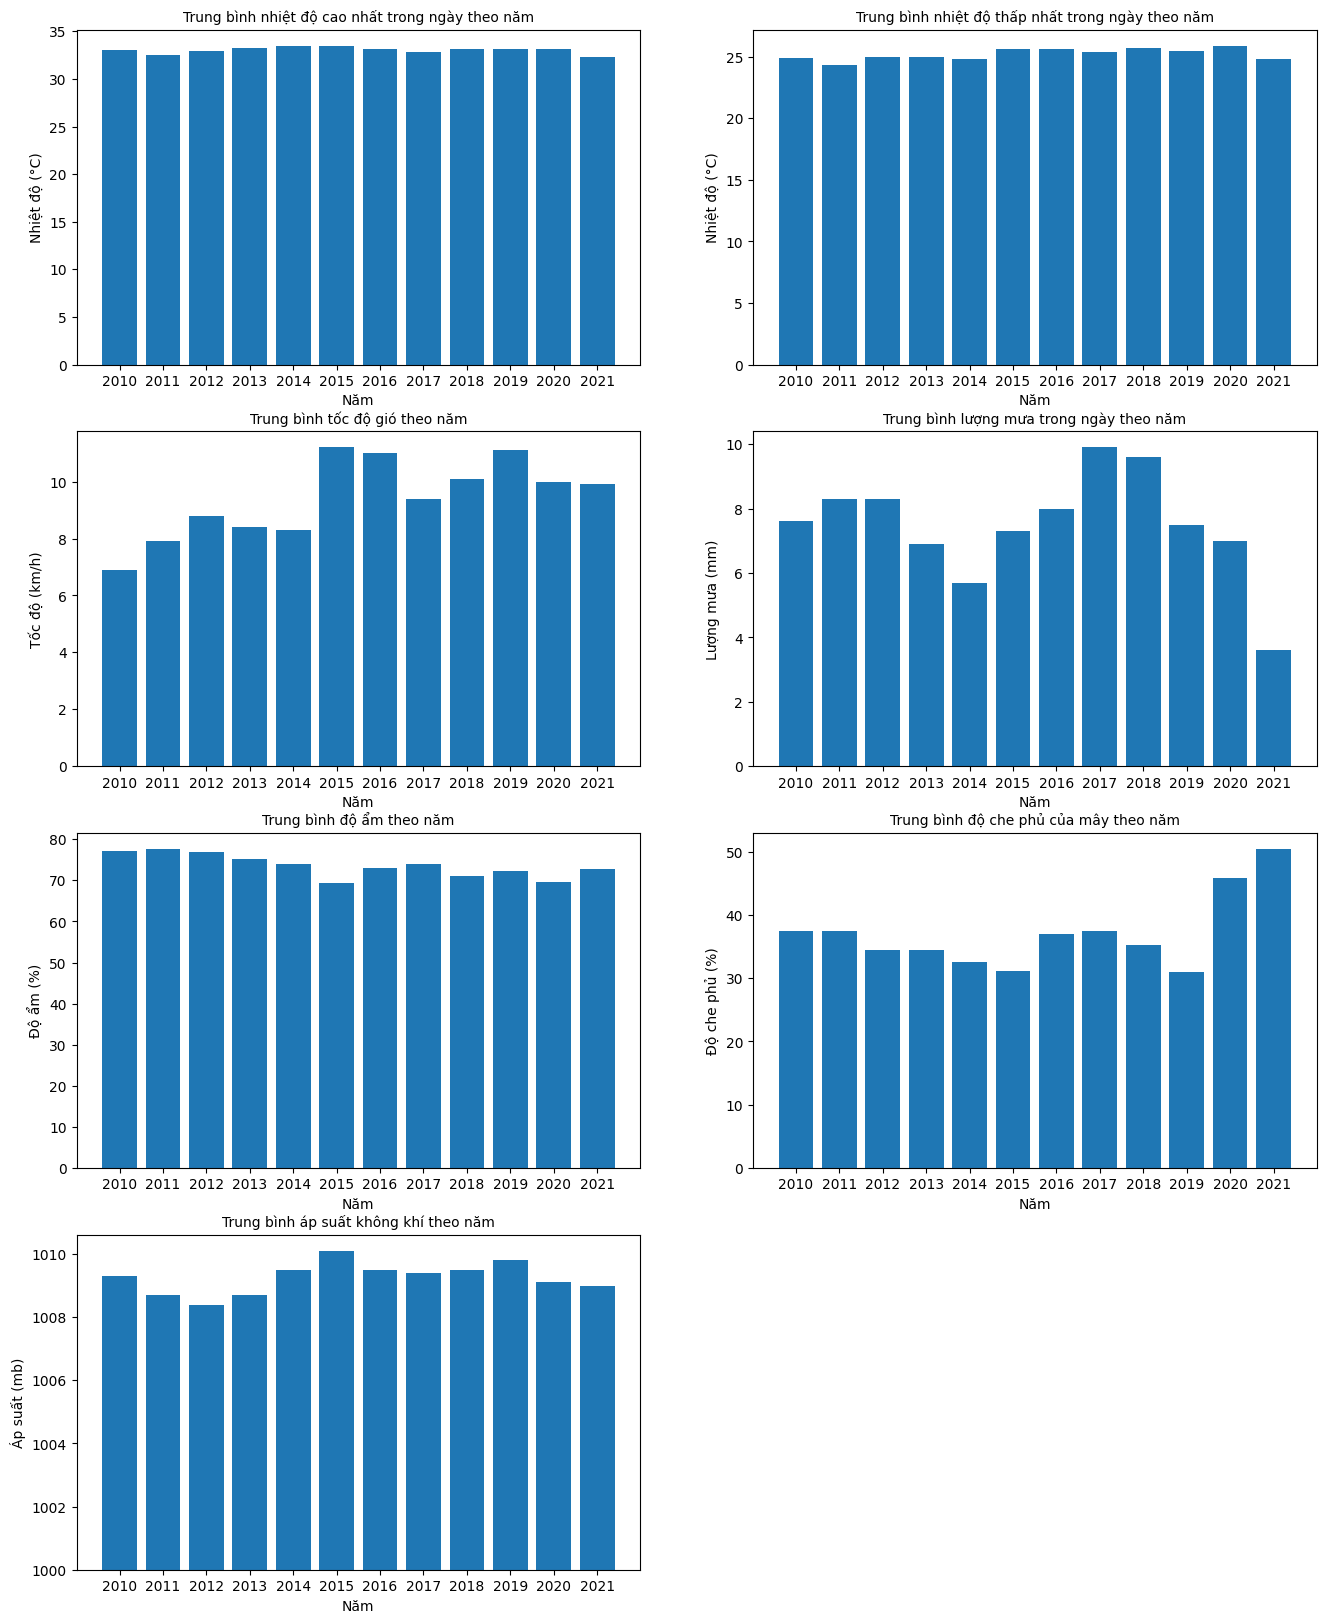

In [19]:
plt.figure(figsize=(16,20))
plt.subplot(4, 2, 1)
font = {'size':10}

plt.bar(x,y1)
plt.xticks(x)
plt.title("Trung bình nhiệt độ cao nhất trong ngày theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Nhiệt độ (°C)",fontdict = font)

#plt.plot(x,y1)

plt.subplot(4, 2, 2)
plt.bar(x,y2)
plt.xticks(x)
plt.title("Trung bình nhiệt độ thấp nhất trong ngày theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Nhiệt độ (°C)",fontdict = font)

plt.subplot(4, 2, 3)
plt.bar(x,y3)
plt.xticks(x)
plt.title("Trung bình tốc độ gió theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Tốc độ (km/h)",fontdict = font)

plt.subplot(4, 2, 4)
plt.bar(x,y4)
plt.xticks(x)
plt.title("Trung bình lượng mưa trong ngày theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Lượng mưa (mm)",fontdict = font)

plt.subplot(4, 2, 5)
plt.bar(x,y5)
plt.xticks(x)
plt.title("Trung bình độ ẩm theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Độ ẩm (%)",fontdict = font)

plt.subplot(4, 2, 6)
plt.bar(x,y6)
plt.xticks(x)
plt.title("Trung bình độ che phủ của mây theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Độ che phủ (%)",fontdict = font)

plt.subplot(4, 2, 7)
plt.bar(x,y7-1000,bottom=1000)
plt.xticks(x)
plt.title("Trung bình áp suất không khí theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Áp suất (mb)",fontdict = font)

#plt.xticks(size=8)
#plt.yticks(size=8)
#plt.legend(loc='center right',fontsize='xx-small')

plt.show()

- Ta có thể thấy trung bình nhiệt độ cao nhất thấp nhất trong ngày, độ ẩm, áp suất không có biến động nhiều qua các năm.
- Tốc độ gió có xu hướng tăng dần và cao nhất vào năm 2015.
- Lượng mưa biến động thất thường, năm thấp nhất là 2021 lượng mưa không bằng một nữa của 2015.
- Độ che phủ của mây có sự tăng đột ngột vào năm 2020 và 2021.</br>
Những phân tích trên nhầm để có cái nhìn tổng quát về sự thay đổi của những chỉ số thời tiết qua các năm.

### Lượng mưa của từng tháng trong các năm biến đổi như thế nào

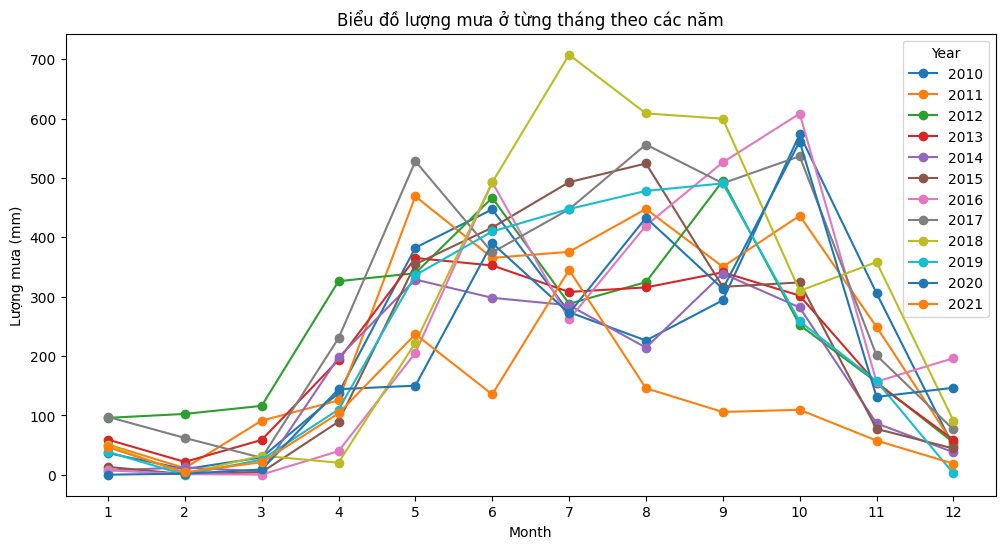

In [20]:
df_rain = df_year.copy()
df_rain['Month'] = df_rain['Date'].dt.month
x = df_rain['Month'].unique()
df_rain[['Year', 'Month', 'Rain']].groupby(['Month','Year']).sum().squeeze().unstack()\
                .plot(marker = 'o',figsize=(12, 6), legend=True, ylabel='Lượng mưa (mm)',\
                      title='Biểu đồ lượng mưa ở từng tháng theo các năm')
plt.xticks(x);

- **Để dễ quan sát hơn, ta sẽ quan sát trên 2 biểu đồ 2010-2015 và 2016-2021**

In [21]:
rain_2010_2015 = np.array_split(df_rain[['Year', 'Month', 'Rain']],2)[0]
rain_2016_2021 = np.array_split(df_rain[['Year', 'Month', 'Rain']],2)[1]

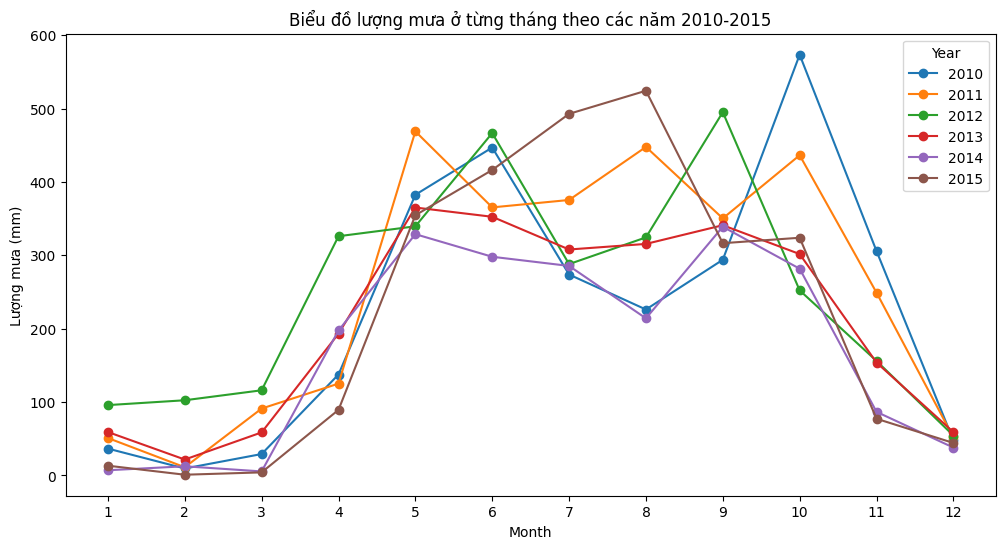

In [22]:
rain_2010_2015.groupby(['Month','Year']).sum().squeeze().unstack()\
                .plot(marker = 'o',figsize=(12, 6), legend=True,ylabel='Lượng mưa (mm)',\
                      title='Biểu đồ lượng mưa ở từng tháng theo các năm 2010-2015')
plt.xticks(x);

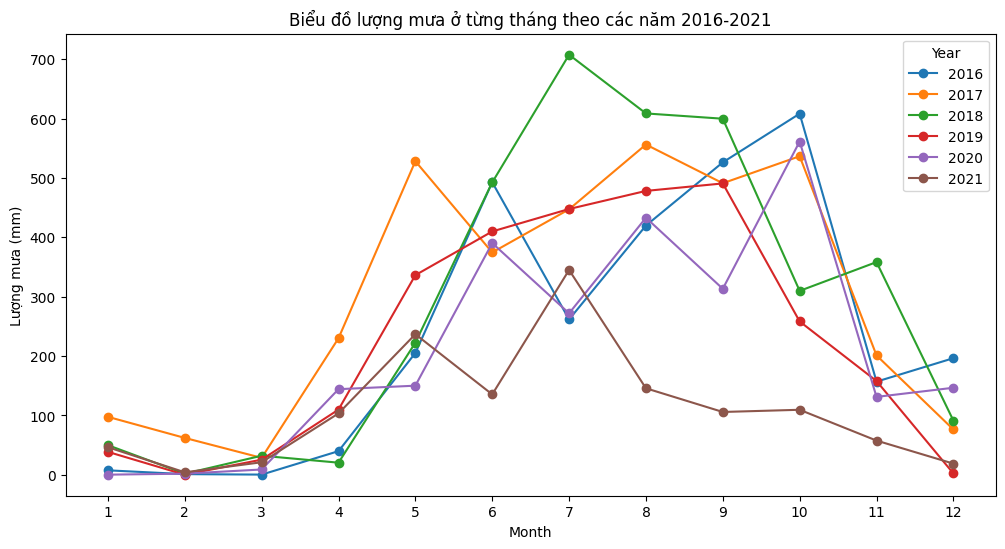

In [23]:
rain_2016_2021.groupby(['Month','Year']).sum().squeeze().unstack()\
                .plot(marker = 'o',figsize=(12, 6), legend=True,ylabel='Lượng mưa (mm)',\
                      title='Biểu đồ lượng mưa ở từng tháng theo các năm 2016-2021')
plt.xticks(x);

* Nhận xét:
    - Tuy có sự khác biệt phần nào giữa các năm. Nhưng nhìn chung lượng mưa duy trì ở mức cao và đạt định trong các tháng từ 5-10.
    - Năm khác biệt nhất là 2021 khi lượng mưa chỉ ở mức cao vào tháng 5 và 7 và cũng tương đối thấp nếu so với cùng kỳ của các năm khác
* Lợi ích đạt được từ câu hỏi:
    - Ta có thể thấy rõ thời gian của mùa mưa và mùa khô ở Tp HCM
* Nguồn cảm hứng:
    - Có thể biết được vào những tháng nào thì ta nên nên chuẩn bị tâm lý xe sẽ chết máy khi lội nước trên những con đường ở tp HCM chẳng hạn :v

### Loại thời tiết nào thường xuyên xuất hiện nhất ở tp HCM

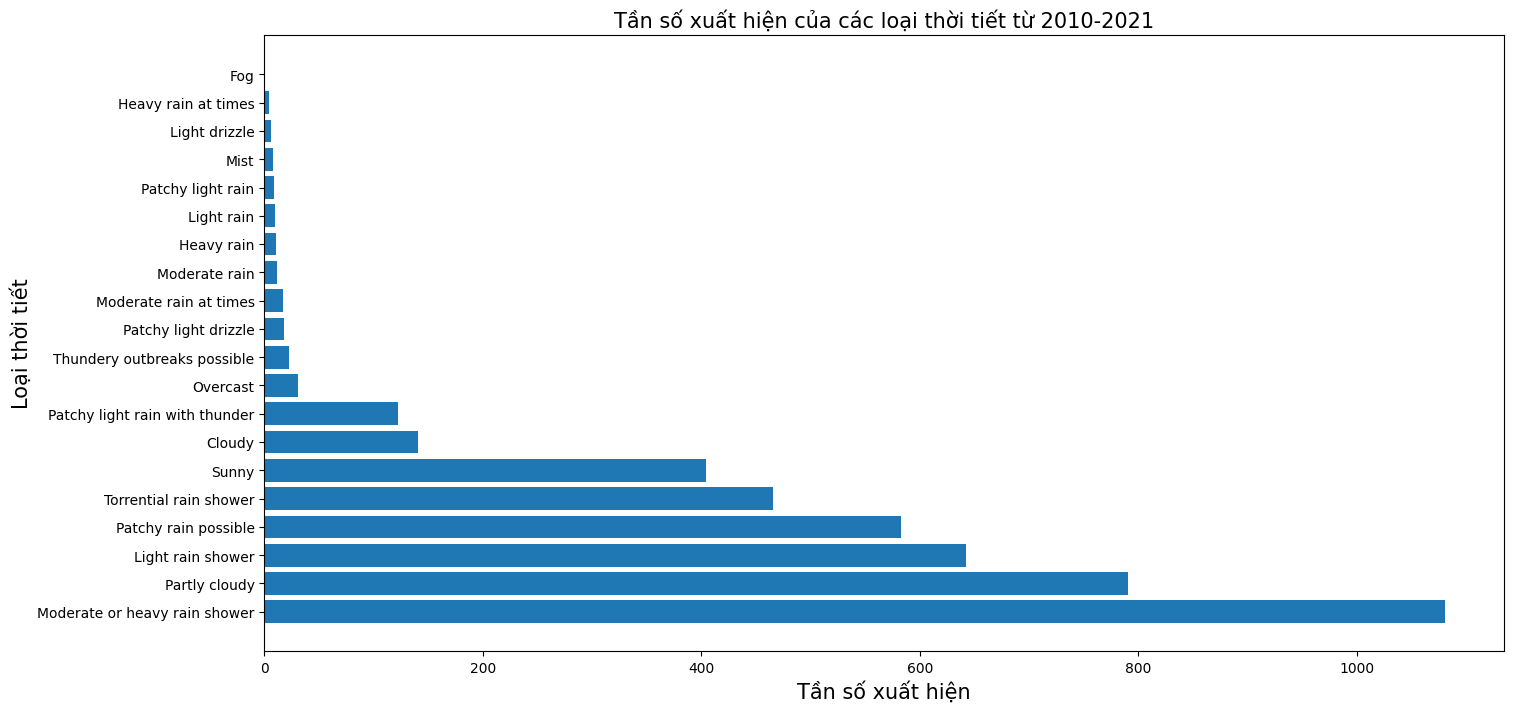

In [24]:
x = df['Weather Type'].value_counts().index
y = df['Weather Type'].value_counts().values

font = {'size': 15}
plt.figure(figsize=(16,8))
plt.barh(x,y)
plt.xlabel('Tần số xuất hiện',fontdict=font)
plt.ylabel('Loại thời tiết',fontdict=font)
plt.title('Tần số xuất hiện của các loại thời tiết từ 2010-2021',fontdict=font)
plt.show()

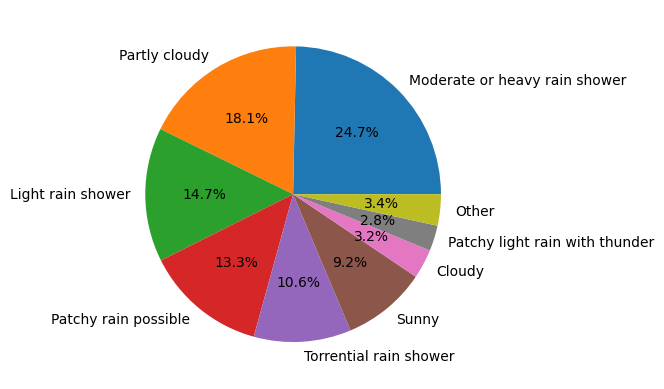

In [25]:
y_pie = y[:8]
y_pie = np.append(y_pie,y[8:].sum())
x_pie = np.append(x[:8],'Other')
plt.pie(y_pie,labels=x_pie,autopct='%1.1f%%');

* Nhận xét:
    - Có 6 kiểu thời tiết phổ biến là: Moderate or heavy rain shower, Partly cloudy, Light rain shower,Patchy rain possible, Torrential rain shower, Sunny chiếm hơn 90%
    - Theo quan sát kiểu thời tiết thì dường như hầu hết không có mưa cũng sẽ có mây
* Lợi ích đạt được từ câu hỏi:
    - Hiểu được kiểu thời tiết ở Tp HCM
* Nguồn cảm hứng:
    - Người ta thường nói Sài Gòn hay có những cơn mưa bất chợt

- So sánh sự chênh lệch nhiệt độ cao nhất và thấp nhất

In [26]:
df_Temperature = df.copy()
df_Temperature['Year'] = df['Date'].dt.year
df_Temperature['Month'] = df['Date'].dt.month
df_Temperature = df_Temperature[['Lowest Temperature','Highest Temperature','Month','Year']]
df_Temperature['Difference'] = df_Temperature['Highest Temperature'] - df_Temperature['Lowest Temperature']

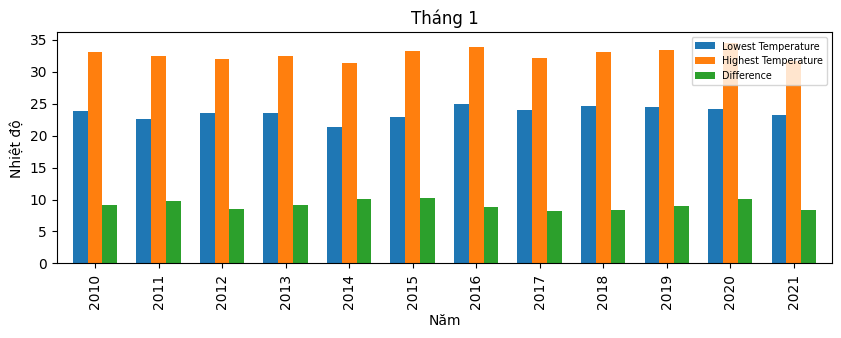

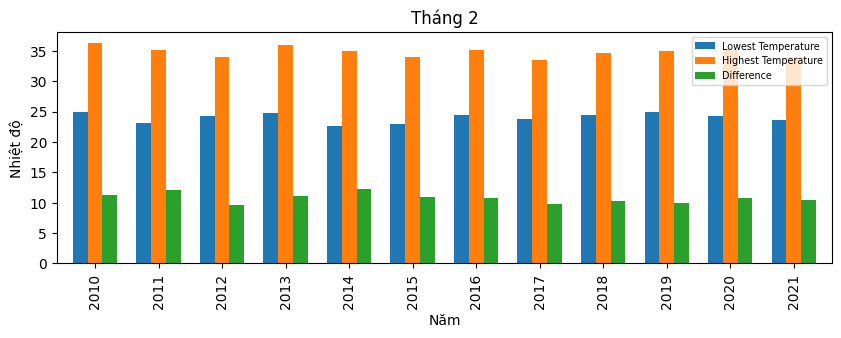

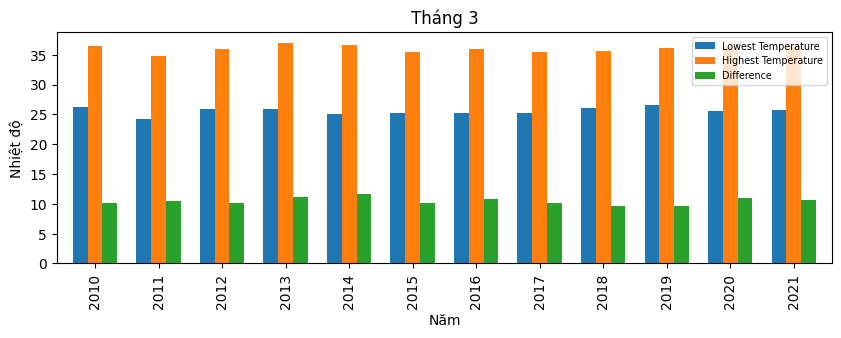

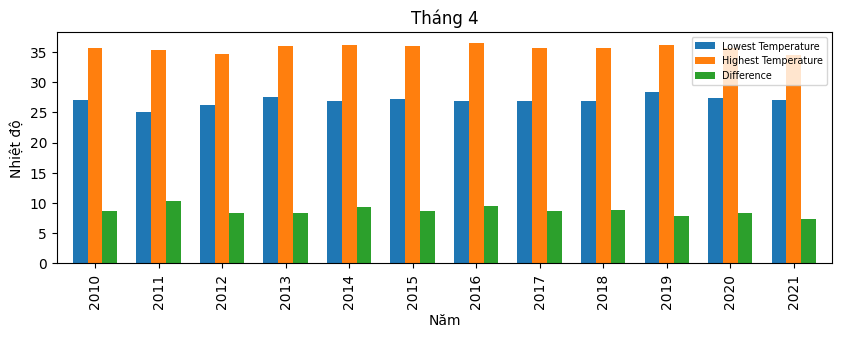

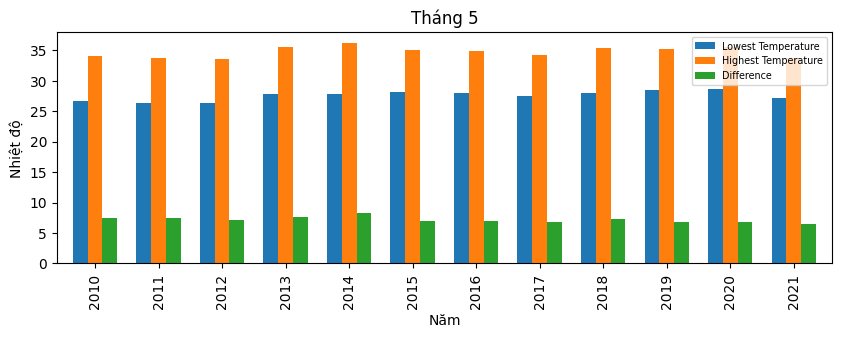

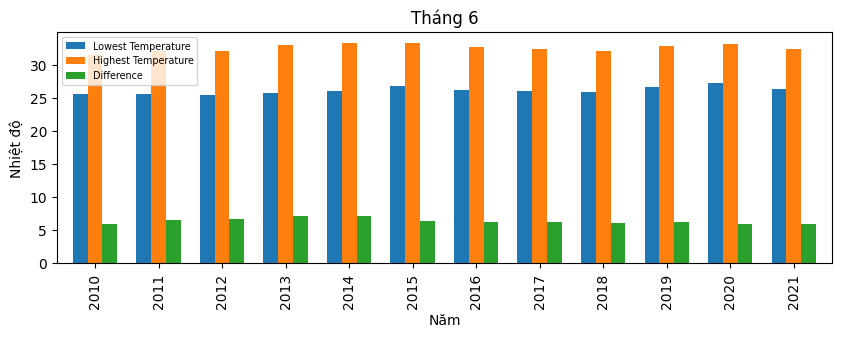

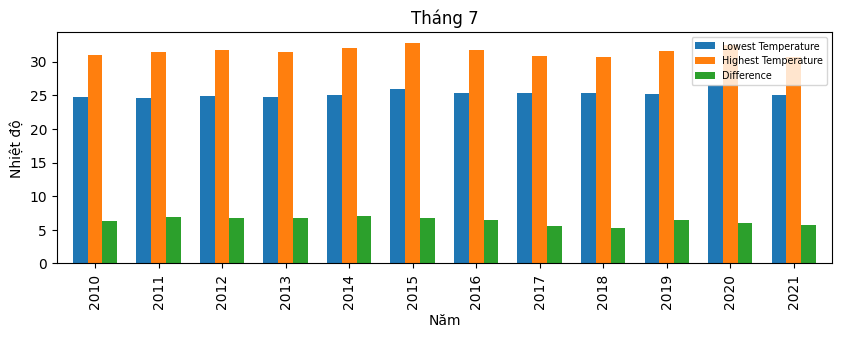

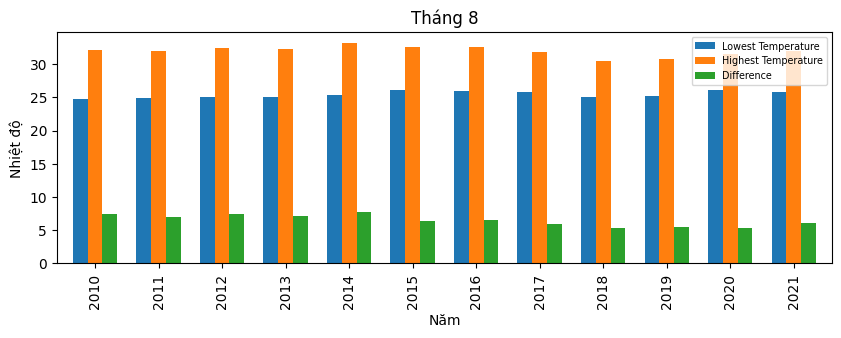

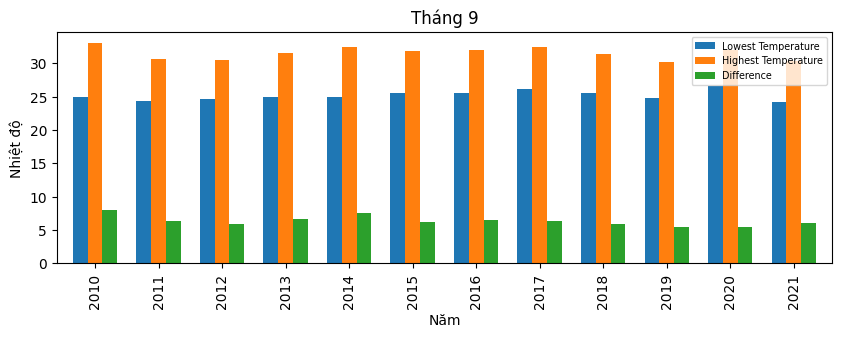

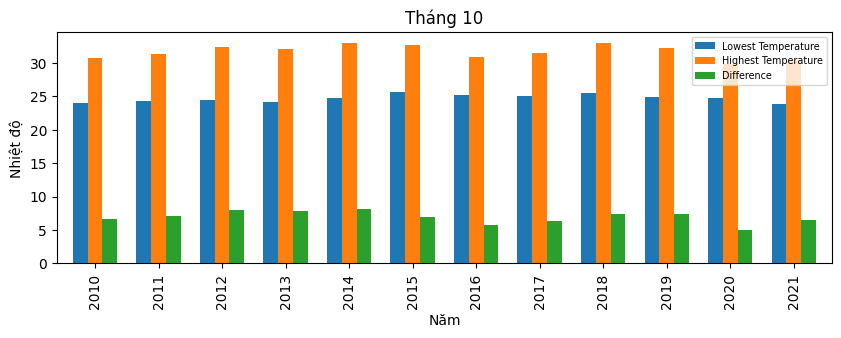

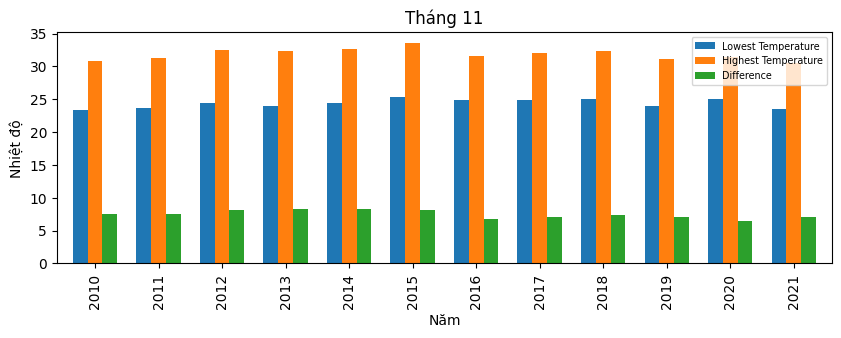

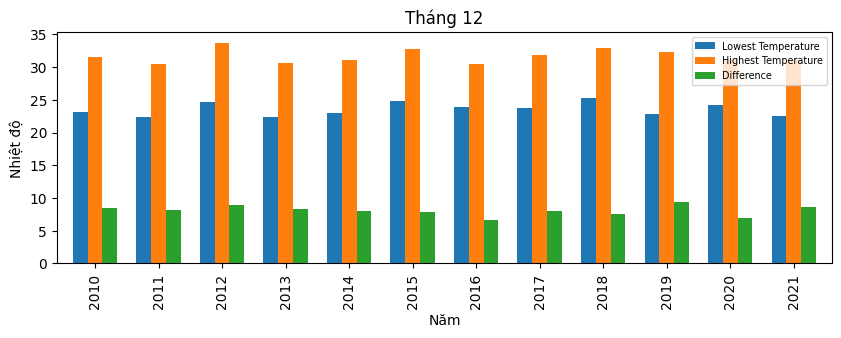

In [27]:
for i in range(1,13,1):
    df_Temperature.groupby(['Month','Year']).mean().round(1).loc[i].plot(kind='bar',width=0.7,figsize=(10,3));
    plt.title(f'Tháng {i}')
    plt.xlabel('Năm')
    plt.ylabel('Nhiệt độ')
    plt.legend(fontsize='x-small')
    plt.show()

- Ta có thể thấy sự biến động về nhiệt độ cao nhất và thấp nhất trong ngày giữa các năm lớn hơn vào ở các tháng cuối năm như 10,11,1.

* Câu hỏi: Mối liên hệ giữa tốc độ gió và độ ẩm đến loại thời tiết

Text(0.5, 1.0, 'Mối quan hệ giữa độ ẩm đến kiểu thời tiết')

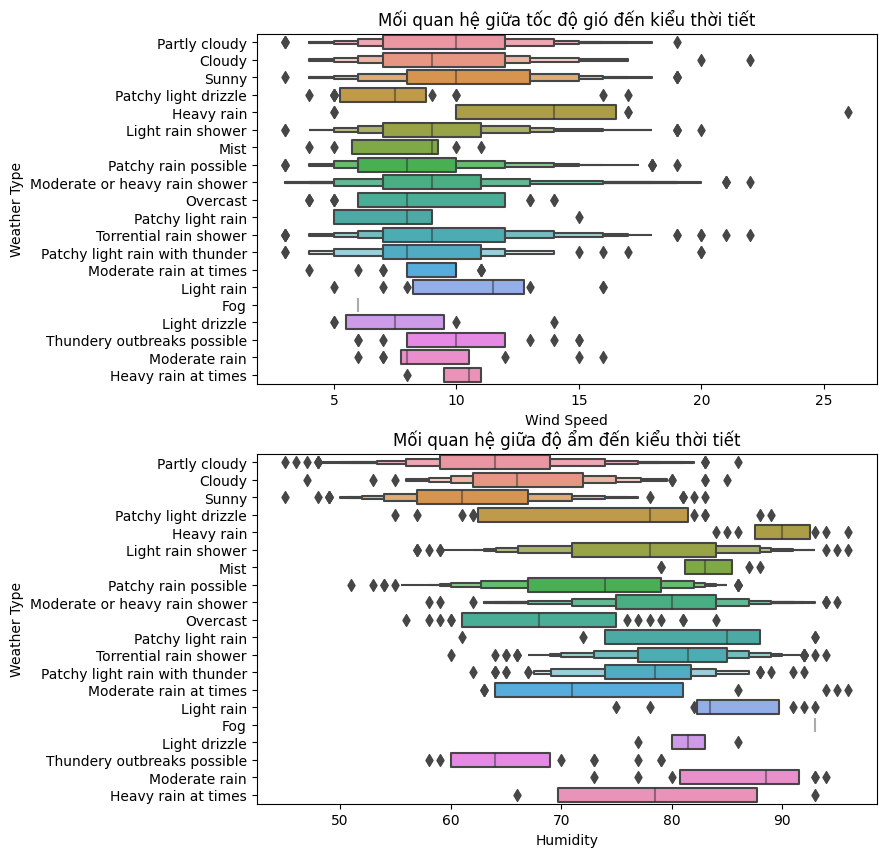

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(8,10))

sns.boxenplot(ax=axes[0],data=df,x='Wind Speed',y='Weather Type')
axes[0].set_title('Mối quan hệ giữa tốc độ gió đến kiểu thời tiết')
sns.boxenplot(ax=axes[1],data=df,x='Humidity',y='Weather Type')
axes[1].set_title('Mối quan hệ giữa độ ẩm đến kiểu thời tiết')

* **Câu hỏi: Số lần xuất hiện trung bình của các loại thời tiết ở các tháng qua các năm?**

Ở đây em chỉ định các loại thời tiết là 'Partly cloudy','Moderate or heavy rain shower', 'Sunny', 'Torrential rain shower','Patchy rain possible'.

Text(0.5, 1.0, 'Số lần xuất hiện trung bình của các loại thời tiết ở các tháng qua các năm?')

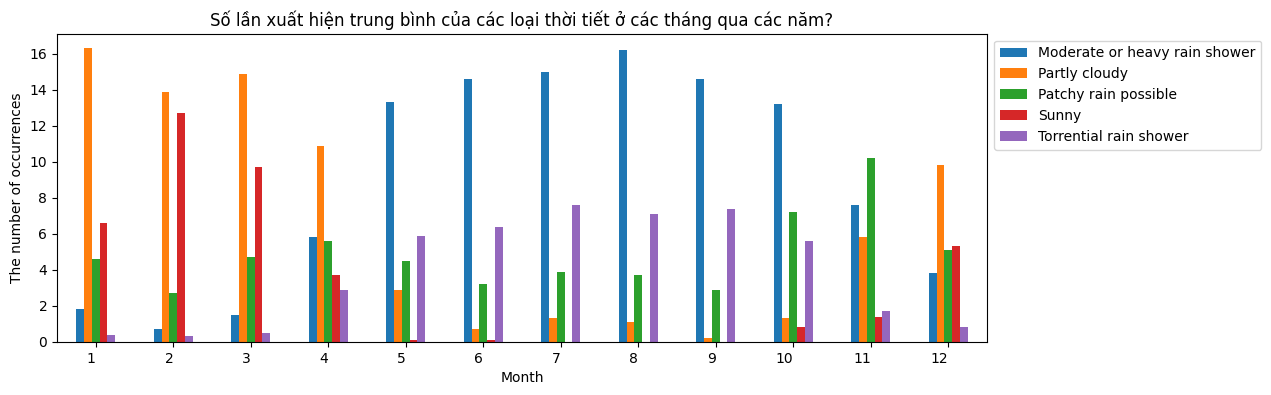

In [29]:
specific_type = ['Partly cloudy','Moderate or heavy rain shower', 'Sunny', 'Torrential rain shower','Patchy rain possible']

df_rain_type = df_rain.copy()
df_rain_type = df_rain_type[df_rain_type['Weather Type'].isin(specific_type)]
df_rain_type.groupby('Month')['Weather Type'].value_counts().divide(other = 10).unstack().plot.bar(figsize=(12,4),  ylabel = 'The number of occurrences')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0, ha='right')
plt.title('Số lần xuất hiện trung bình của các loại thời tiết ở các tháng qua các năm?')

* Lợi ích từ câu hỏi: Biết được các tháng mà các loại thời tiết này thường xuất hiện mà ta có thể chủ động trong các tình huống như: 
  * Lựa chọn việc di chuyển bằng các phương tiện công cộng
  * Có sự lưu ý về những tháng có nhiều mưa.
  * Chọn được những tháng có thời tiết đẹp để đi dạo phố.
* Như biểu đồ ta có thể thấy là những tháng có nhiều ngày đẹp trời thường rơi vào tháng 1 đến tháng 3. Đó là khoảng thời gian Tết của Việt Nam, rất thích hợp cho việc đi chơi!

* **Câu hỏi: Sự tương quan giữa Nhiệt độ cao nhất và Độ ẩm trung bình ở các tháng qua các năm**

C:\Users\Asus\AppData\Local\Temp\ipykernel_10668\1363642300.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month_year = df.groupby([(df.Date.dt.year), (df.Date.dt.month)]).mean()


Text(0.5, 1.0, 'Sự tương quan giữa Nhiệt độ cao nhất và Độ ẩm trung bình ở các tháng qua các năm')

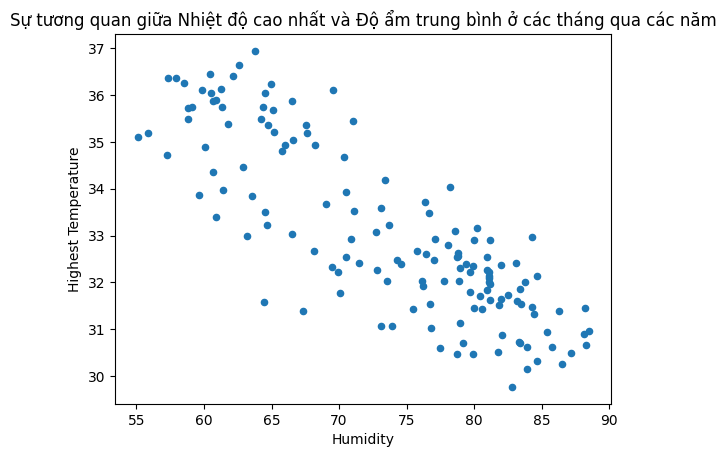

In [30]:
df_month_year = df.groupby([(df.Date.dt.year), (df.Date.dt.month)]).mean()
df_month_year.plot('Humidity', 'Highest Temperature', kind = 'scatter')
plt.title('Sự tương quan giữa Nhiệt độ cao nhất và Độ ẩm trung bình ở các tháng qua các năm')

* Từ biểu đồ ta có thể thấy nhiệt độ và độ ẩm luôn là yếu tố song hành và tác động qua lại lẫn nhau. Khi nhiệt độ tăng đồng nghĩa tốc độ bay hơi của nước ngày càng nhanh, độ ẩm trong không khí sẽ giảm và ngược lại. Đây là hiện tượng quen thuộc vào những ngày nóng nực mùa hè.
* Nhiệt độ và độ ẩm là hai thông số ảnh hưởng trực tiếp đến sức khỏe con người. Vào mùa đông, bạn sẽ rất dễ gặp phải những loại bệnh về đường hô hấp và nứt da, chảy máu tại các vùng da khô như khuỷu tay, gót chân. Và những ngày mùa hè nóng nực, chúng ta sẽ rất dễ bị choáng váng do mất nước và say nắng do nhiệt độ cao.
* Để đảm bảo sức khỏe cho bản thân và gia đình, bạn cần trang bị những kiến thức về nhiệt độ và độ ẩm là điều cần thiết. VD: cân bằng độ ẩm trong không gian sống của mình bằng cách sử dụng máy hút ẩm, điều hòa, dùng giẻ khô để lau nhà,...